## Prompting

In [8]:
import json
import random

import matplotlib.pyplot as plt
import numpy as np

In [9]:
def vote_by_majority(responses):
    votes = dict()
    passed = dict()
    
    for response in responses:
        source = response[0]
        source = '\n'.join(
            [
                line for line in source.split('\n') 
                if not line.startswith('```') and not line.strip().startswith('def ')
            ])
        if source not in votes:
            passed[source] = response[1]['result'] == "passed"
            votes[source] = 0
        votes[source] += 1
    
    max_votes = max(votes.values())
    top_sources = [src for src, count in votes.items() if count == max_votes]
    chosen_source = random.choice(top_sources)
    
    return chosen_source, max_votes, passed[chosen_source]

def pass_at_any_for(responses_path):
    with open(responses_path) as f:
        benchmark_responses = json.load(f)
    
    passed_count = 0
    for id in benchmark_responses:
        source, votes, is_passed = vote_by_majority(benchmark_responses[id])
        if is_passed:
            passed_count += 1
    
    return passed_count


In [10]:
def pretty_print_results(benchmark, models, verbose=True):
    model_wise_results = list()
    for model in models:
        results = [
            pass_at_any_for(f'results/{benchmark}_{model}.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_instruction.json'),
            pass_at_any_for(f'results/{benchmark}_{model}_rule.json'),
        ]
        if verbose:
            print(model, '\t'.join(map(str, results)), sep='\t')
        model_wise_results.append(results)
    return model_wise_results

In [11]:
def load_and_visualize(benchmark, models, technique_wise_results):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]

    x = np.arange(len(models))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, data1, width, label='Baseline', color='#7fc97f')
    bars2 = ax.bar(x, data2, width, label='Instruction', color='#beaed4')
    bars3 = ax.bar(x + width, data3, width, label='Rule', color='#fdc086')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'$\it{pass@1}$')
    ax.set_title(benchmark + r' $\it{pass@1}$ by Model and Prompt')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_prompts.png', dpi=300)

llama3	54	51	19
llama3.1	85	81	47
mistral-nemo	56	56	45
qwen2.5-coder	108	124	120


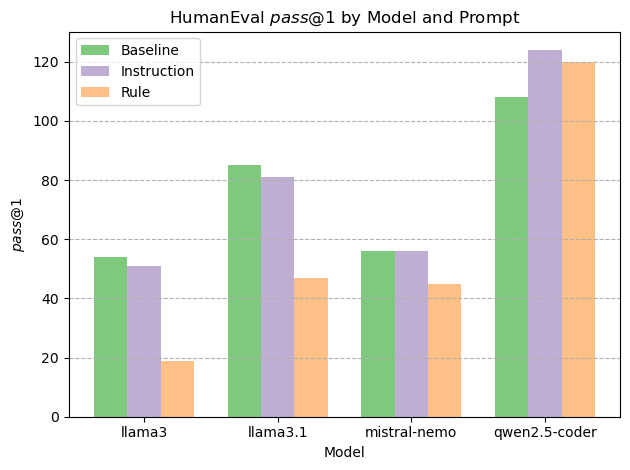

In [12]:
random.seed(42)

benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

model_wise_results = pretty_print_results(benchmark, models)
technique_wise_results = [[model_wise_results[j][i] for j in range(4)] for i in range(3)]
load_and_visualize(benchmark, models, technique_wise_results)

llama3	23	19	17
llama3.1	17	11	1
mistral-nemo	30	32	15
qwen2.5-coder	21	14	6


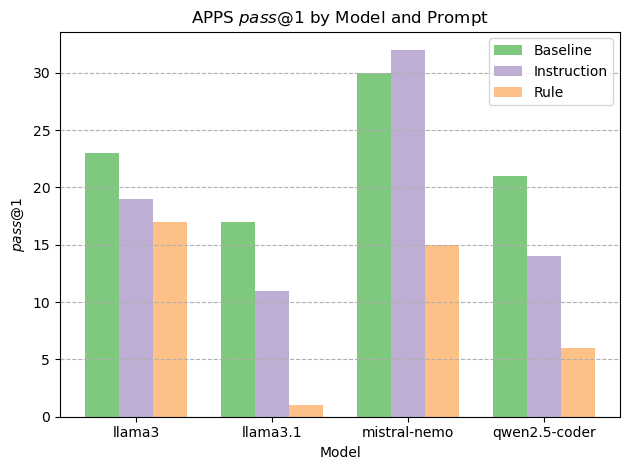

In [13]:
random.seed(42)

benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

model_wise_results = pretty_print_results(benchmark, models)
technique_wise_results = [[model_wise_results[j][i] for j in range(4)] for i in range(3)]
load_and_visualize(benchmark, models, technique_wise_results)

In [14]:
def load_and_visualize_vote_method(benchmark, models, technique_wise_results, vote_method):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]

    x = np.arange(len(models))  # label locations
    width = 0.25  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width, data1, width, label='Baseline', color='#7fc97f')
    bars2 = ax.bar(x, data2, width, label='Instruction', color='#beaed4')
    bars3 = ax.bar(x + width, data3, width, label='Rule', color='#fdc086')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'$\it{pass@1}$')
    ax.set_title(benchmark + r' $\it{pass@1}$ by Model and Prompt')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_{vote_method}.png', dpi=300)

In [15]:
### Naryeong - Load the results

def load_results(result_file_path):
    technique_wise_results = [[] * 4 for _ in range(3)]

    prompt = None
    with open(result_file_path, 'r') as f:
        for l in f:
            if 'instruction' in l:
                prompt = 'instruction'
            elif 'rule' in l:
                prompt = 'rule'
            elif 'num' not in l and '=' not in l:
                prompt = 'normal'
            elif 'num_passed' in l:
                num_passed = int(l[12:])
                
                if prompt == 'normal':
                    technique_wise_results[0].append(num_passed)
                elif prompt == 'instruction':
                    technique_wise_results[1].append(num_passed)
                elif prompt == 'rule':
                    technique_wise_results[2].append(num_passed)
    
    return technique_wise_results

### Embedding - Cosine Similarity

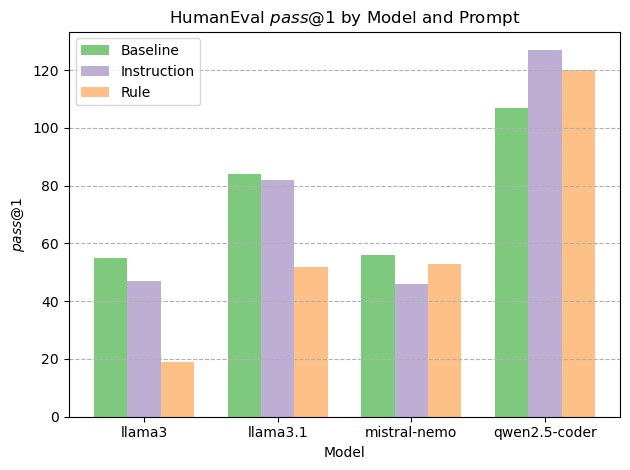

In [16]:
## Human Eval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
result_file = f'./similarity/codebert_{benchmark.lower()}_results.txt'

technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'emb_sim')

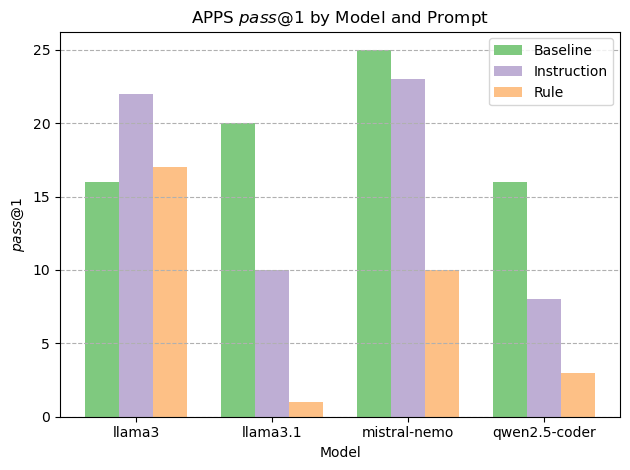

In [17]:
## APPS
benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'emb_sim')

### AST Edit distance

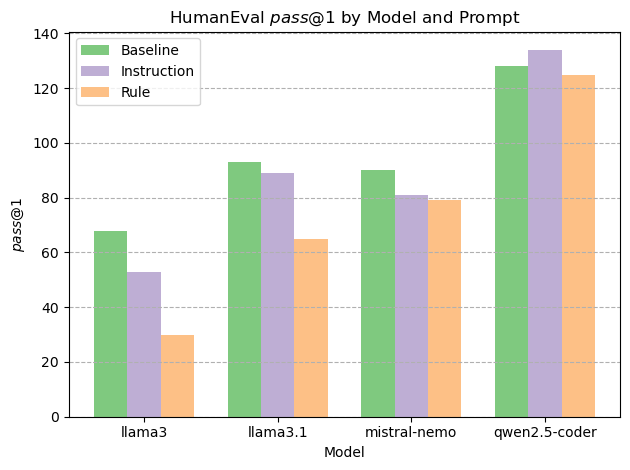

In [18]:
## Human Eval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
result_file = f'./similarity/ast_edit_dist_{benchmark.lower()}_wo_preprocessing_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'ast_dist')

### Embedding - KMean Clustering

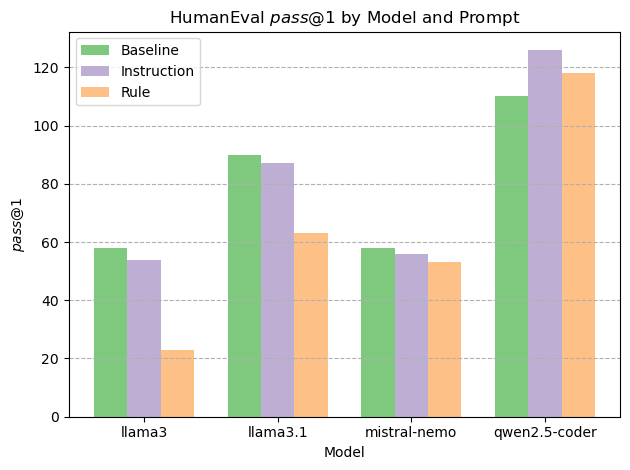

In [19]:
## HumanEval
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_kmean_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'clustering')

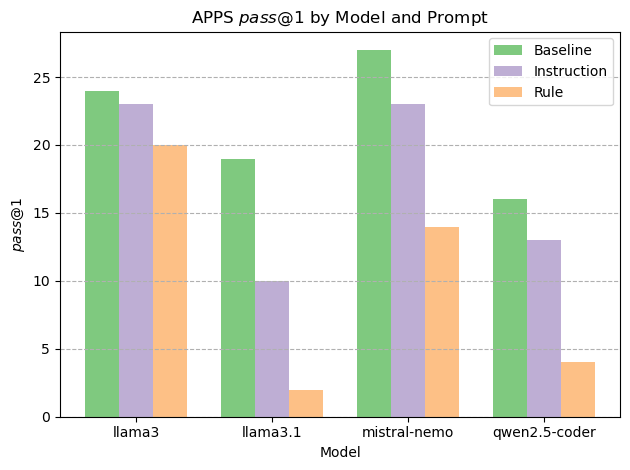

In [20]:
## APPS
benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']

result_file = f'./similarity/codebert_kmean_{benchmark.lower()}_results.txt'
technique_wise_results = load_results(result_file)
load_and_visualize_vote_method(benchmark, models, technique_wise_results, 'clustering')

## HumanEval qwen2.5-coder(instruction) Comparison

[[68, 93, 90, 128], [53, 89, 81, 134], [30, 65, 79, 125]]


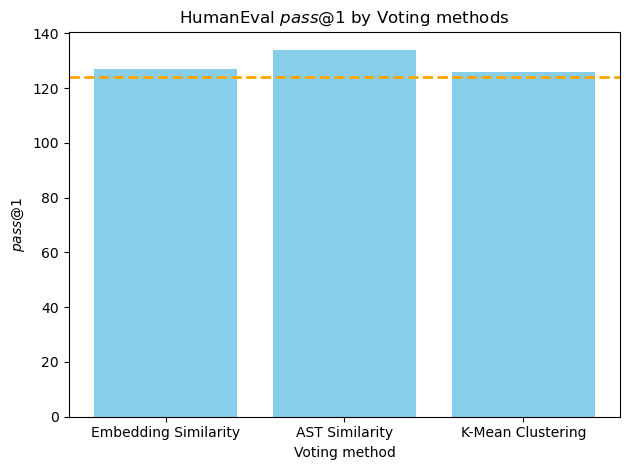

In [21]:


benchmark = 'HumanEval'

## add x element
x_axis = ['Embedding Similarity', 'AST Similarity', 'K-Mean Clustering']

embedding_sim = load_results('./similarity/codebert_humaneval_results.txt')
ast_sim = load_results('./similarity/ast_edit_dist_humaneval_wo_preprocessing_results.txt')
print(ast_sim)
cluster = load_results('./similarity/codebert_kmean_humaneval_results.txt')

# Qwen2.5-coder(instuction)
## add y-value
y_value = []
y_value.append(embedding_sim[1][3])
y_value.append(ast_sim[1][3])
y_value.append(cluster[1][3])

baseline_y_value = 124

x = np.arange(len(x_axis))
width = 0.25

plt.bar(x_axis, y_value, color = 'skyblue')
plt.axhline(y=baseline_y_value, color = 'orange', linestyle='--', linewidth=2, label=f'Baseline ({baseline_y_value})')
plt.title(benchmark + r' $\it{pass@1}$ by Voting methods')
plt.xlabel('Voting method')
plt.ylabel(r'$\it{pass@1}$')
plt.tight_layout()
plt.savefig(f'results/figures/{benchmark}_qwen_inst.png', dpi=300)

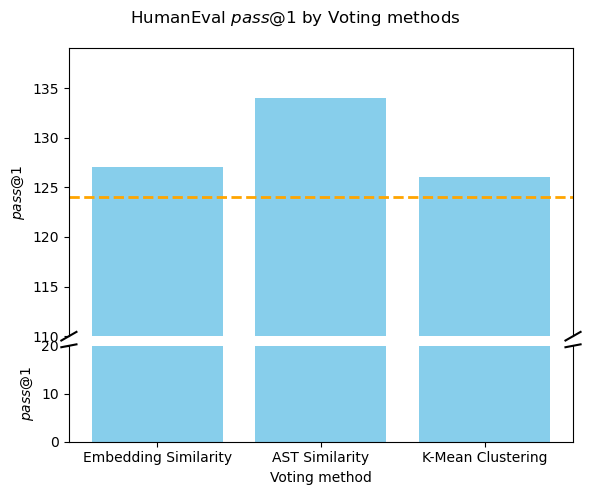

In [22]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(6, 5), 
                                        gridspec_kw={'height_ratios': [3, 1]})

# 위쪽 축 (생략된 위 구간)
ax_top.bar(x, y_value, color='skyblue')
ax_top.axhline(y=baseline_y_value, color='orange', linestyle='--', linewidth=2, label=f'Baseline ({baseline_y_value})')
ax_top.set_ylim(110, max(y_value) + 5)
ax_top.spines['bottom'].set_visible(False)
ax_top.tick_params(bottom=False)

# 아래쪽 축 (생략된 아래 구간)
ax_bottom.bar(x, y_value, color='skyblue')
ax_bottom.set_ylim(0, 20)
ax_bottom.spines['top'].set_visible(False)

# 물결선 표시
d = 0.015  # 물결 기울기
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
ax_top.plot([-d, +d], [-d, +d], **kwargs)
ax_top.plot([1 - d, 1 + d], [-d, +d], **kwargs)

kwargs.update(transform=ax_bottom.transAxes)
ax_bottom.plot([-d, +d], [1 - d, 1 + d], **kwargs)
ax_bottom.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)

# 라벨, 제목
fig.suptitle('HumanEval $\it{pass@1}$ by Voting methods')
ax_bottom.set_xlabel('Voting method')
ax_top.set_ylabel(r'$\it{pass@1}$')
ax_bottom.set_ylabel(r'$\it{pass@1}$')
plt.xticks(x, x_axis)

# 저장
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)
plt.savefig('results/figures/HumanEval_qwen_inst_wavy_cut_20_90.png', dpi=300)
plt.show()

# Sample Selection on Baseline Prompt

In [23]:
def load_and_visualize_sample_selection(benchmark, models, technique_wise_results, prompt_type):
    data1 = technique_wise_results[0]
    data2 = technique_wise_results[1]
    data3 = technique_wise_results[2]
    data4 = technique_wise_results[3]

    x = np.arange(len(models))  # label locations
    width = 0.20  # width of the bars

    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width * 1.5, data1, width, label='Vanilla Voting', color='#7fc97f')
    bars2 = ax.bar(x - width * 0.5, data2, width, label='Embedding Similarity', color='#beaed4')
    bars3 = ax.bar(x + width * 0.5, data3, width, label='AST Similarity', color='#fdc086')
    bars4 = ax.bar(x + width * 1.5, data4, width, label='K-Means Clustering', color='#ffff99')

    ax.set_xlabel('Model')
    ax.set_ylabel(r'$\it{pass@1}$')
    ax.set_title(benchmark + r' $\it{pass@1}$ by Model and Sample Selection' + f' ({prompt_type})')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.grid(True, axis='y', linestyle='--')
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'results/figures/{benchmark}_selections_{prompt_type}.png', dpi=300)

In [24]:
def load_sample_selection_results_for_prompting(benchmark, models, prompt_index):
    technique_wise_results = list()

    model_wise_results = pretty_print_results(benchmark, models, verbose=False)
    technique_wise_results.append([[model_wise_results[j][i] for j in range(4)] for i in range(3)][prompt_index]) # vanilla voting

    result_file = f'./similarity/codebert_{benchmark.lower()}_results.txt'
    technique_wise_results.append(load_results(result_file)[prompt_index])

    result_file = f'./similarity/ast_edit_dist_{benchmark.lower()}_wo_preprocessing_results.txt'
    technique_wise_results.append(load_results(result_file)[prompt_index])

    result_file = f'./similarity/codebert_kmean_{benchmark.lower()}_results.txt'
    technique_wise_results.append(load_results(result_file)[prompt_index])

    return technique_wise_results

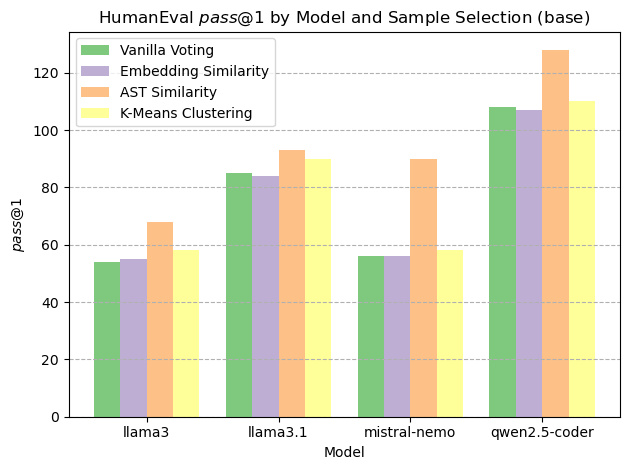

In [25]:
benchmark = 'HumanEval'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
prompt_index = 0
prompt_index_to_name = {0: 'base', 1: 'instruction', 2: 'rule'}

random.seed(42)

technique_wise_results = load_sample_selection_results_for_prompting(benchmark, models, prompt_index)
load_and_visualize_sample_selection(benchmark, models, technique_wise_results, prompt_index_to_name[prompt_index])

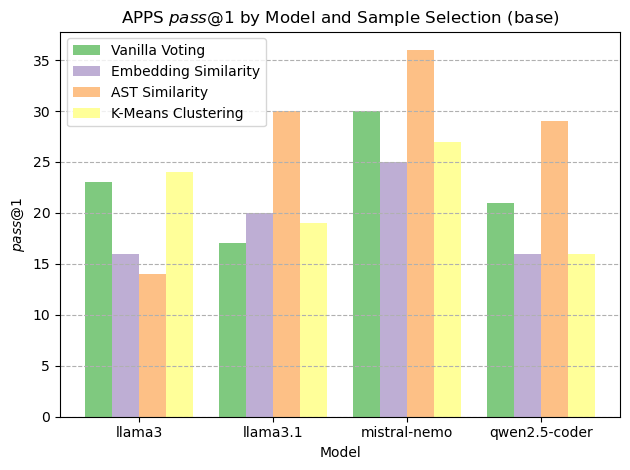

In [26]:
benchmark = 'APPS'
models = ['llama3', 'llama3.1', 'mistral-nemo', 'qwen2.5-coder']
prompt_index = 0
prompt_index_to_name = {0: 'base', 1: 'instruction', 2: 'rule'}

random.seed(42)

technique_wise_results = load_sample_selection_results_for_prompting(benchmark, models, prompt_index)
load_and_visualize_sample_selection(benchmark, models, technique_wise_results, prompt_index_to_name[prompt_index])

# Plotting Pass Rate and Entropy

In [28]:
import pandas as pd
import seaborn as sns
import os

In [29]:
def load_json_to_dataframe (json_data):
    """
    Reads JSON data, calculates pass rates, and returns DataFrame.

    Args:
        json_data (dict): 
            The dictionary containing your benchmark results.
            Keys are paths, values are dictionaries with 'model', 'mode', 'dataset',
                'passed_count', 'total_count', 'entropy'.
        output_filename (str): 
            The name of the file to save the plot.
    """
    
    data_points = []
    for path, metrics in json_data.items():
        pass_rate = (metrics['passed_count'] / metrics['total_count']) * 100
        data_points.append({
            'dataset': metrics['dataset'] if metrics['dataset'] != 'default' else 'Baseline',
            'model': metrics['model'],
            'mode': metrics['mode'],
            'pass_rate': pass_rate,
            'entropy': metrics['entropy']
        })

    df = pd.DataFrame(data_points)
    return df

def plot_pass_rate_vs_entropy (df, output_filename="./results/figures/pass_rate_vs_entropy.png"):
    # --- Define colors for modes ---
    mode_colors = {'default': '#7fc97f', 'instruction': '#beaed4', 'rule': '#fdc086'}
    # --- Define marker shapes for models ---
    model_markers = {'llama3': 'o', 'llama3.1': '^', 'mistral-nemo': 's', 'qwen2.5-coder': 'D'}
    plt.figure(figsize=(24, 18)) # Adjust figure size as needed

    # Create a scatter plot
    datasets = df['dataset'].unique()
    for dataset in datasets:
        subset = df[df['dataset'] == dataset]
        for _, row in subset.iterrows():
            plt.scatter(
                row['pass_rate'], row['entropy'],
                color=mode_colors[row['mode']],
                marker=model_markers[row['model']], 
                s=100, edgecolors='k', linewidth=0.8, zorder=2
            )
            plt.text(row['pass_rate'] + 0.8, row['entropy'], f"{row['dataset']}",
                     fontsize=9, ha='left', va='center', color='dimgray')

    plt.xlabel('Pass Rate (%)', fontsize=12)
    plt.ylabel('Entropy', fontsize=12)
    plt.title('Pass Rate vs. Entropy by Model, Mode, and Dataset', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6, zorder=1)

    # Create separate legends for mode colors and model shapes

    # 1. Legend for Modes (Colors)
    handles_modes = []
    labels_modes = []
    for mode_label in ['default', 'instruction', 'rule']:
        if mode_label in mode_colors: 
            handles_modes.append(plt.Line2D([0], [0], linestyle='none', marker='o', color=mode_colors[mode_label], markersize=10))
            display_label = "Baseline" if mode_label == "default" else mode_label.capitalize()
            labels_modes.append(display_label)
    legend_modes = plt.legend(handles_modes, labels_modes, title='Mode (Color)',
                              bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, borderaxespad=0.)

    # 2. Legend for Models (Shapes) - Create this as a separate legend
    handles_models = []
    labels_models = []
    for model_label in sorted(df['model'].unique()):
        if model_label in model_markers:
            handles_models.append(plt.Line2D([0], [0], linestyle='none', marker=model_markers[model_label], color='gray', markersize=10))
            labels_models.append(model_label)
    legend_models = plt.legend(handles_models, labels_models, title='Model (Shape)',
                               bbox_to_anchor=(1.05, 0.65), loc='upper left', frameon=True, borderaxespad=0.)   
    plt.gca().add_artist(legend_modes)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig(output_filename, dpi=120)
    plt.show()

In [30]:
def plot_by_model_subplots(df, output_filename="./results/figures/pass_rate_vs_entropy_by_model.png"):
    models = sorted(df['model'].unique())
    num_models = len(models)    
    n_cols = 2
    n_rows = 1 + (num_models - 1) // n_cols
    # --- Define colors for modes ---
    mode_colors = {'default': '#7fc97f', 'instruction': '#beaed4', 'rule': '#fdc086'}
    # --- Define marker shapes for models ---
    model_markers = {'llama3': 'o', 'llama3.1': '^', 'mistral-nemo': 's', 'qwen2.5-coder': 'D'}
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 8 * n_rows), squeeze=False)
    axes = axes.flatten() 

    fig.suptitle('Pass Rate vs. Entropy: Comparison by Model', fontsize=20, y=1.02)

    for i, model_name in enumerate(models):
        ax = axes[i]
        subset_model = df[df['model'] == model_name]

        for _, row in subset_model.iterrows():
            ax.scatter(
                row['pass_rate'], row['entropy'],
                color=mode_colors[row['mode']],  
                marker=model_markers[row['model']], 
                s=200, edgecolors='k', linewidth=1.0, zorder=2
            )
            # Add text label for dataset next to each point
            ax.text(row['pass_rate'] + 0.8, row['entropy'], f"{row['dataset']}",
                     fontsize=9, ha='left', va='center', color='dimgray')

        ax.set_title(f'Model: {model_name}', fontsize=14)
        ax.set_xlabel('Pass Rate (%)', fontsize=12)
        ax.set_ylabel('Entropy', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=1)

        # Set consistent axis limits across all subplots for better comparison
        # You might need to uncomment and adjust min/max_pass_rate, min/max_entropy
        # ax.set_xlim(min_pass_rate, max_pass_rate)
        # ax.set_ylim(min_entropy, max_entropy)
        
        # Add a placeholder legend for modes (colors) to each subplot
        handles_modes = []
        labels_modes = []
        for mode_label in ['default', 'instruction', 'rule']:
            if mode_label in mode_colors:
                handles_modes.append(plt.Line2D([0], [0], linestyle='none', marker='o', color=mode_colors[mode_label], markersize=10))
                display_label = "Baseline" if mode_label == "default" else mode_label.capitalize()
                labels_modes.append(display_label)
        ax.legend(handles_modes, labels_modes, title='Mode', loc='best', fontsize=9)


    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.savefig(output_filename, dpi=120)
    plt.show()

def plot_by_mode_subplots(df, output_filename="./results/figures/pass_rate_vs_entropy_by_mode.png"):
    modes = sorted(df['mode'].unique()) # Sort modes for consistent order
    num_modes = len(modes)
    n_cols = 2
    n_rows = 1 + (num_modes - 1) // n_cols
    # --- Define colors for modes ---
    mode_colors = {'default': '#7fc97f', 'instruction': '#beaed4', 'rule': '#fdc086'}
    # --- Define marker shapes for models ---
    model_markers = {'llama3': 'o', 'llama3.1': '^', 'mistral-nemo': 's', 'qwen2.5-coder': 'D'}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10 * n_cols, 8 * n_rows), squeeze=False)
    axes = axes.flatten()

    fig.suptitle('Pass Rate vs. Entropy: Comparison by Mode', fontsize=20, y=1.02)

    for i, mode_name in enumerate(modes):
        ax = axes[i]
        subset_mode = df[df['mode'] == mode_name]

        for _, row in subset_mode.iterrows():
            ax.scatter(
                row['pass_rate'], row['entropy'],
                color=mode_colors[row['mode']], 
                marker=model_markers[row['model']], 
                s=200, edgecolors='k', linewidth=1.0, zorder=2
            )
            ax.text(row['pass_rate'] + 0.8, row['entropy'], f"{row['dataset']}",
                     fontsize=9, ha='left', va='center', color='dimgray')

        display_mode_title = "Baseline" if mode_name == "default" else mode_name.capitalize()
        ax.set_title(f'Mode: {display_mode_title}', fontsize=14)
        ax.set_xlabel('Pass Rate (%)', fontsize=12)
        ax.set_ylabel('Entropy', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6, zorder=1)

        handles_models = []
        labels_models = []
        for model_label in sorted(df['model'].unique()): 
            handles_models.append(plt.Line2D([0], [0], linestyle='none', marker=model_markers[model_label], 
                                             color=mode_colors[row['mode']], markersize=10))
            labels_models.append(model_label)
        ax.legend(handles_models, labels_models, title='Model', loc='best', fontsize=9)


    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(output_filename, dpi=120)
    plt.show()

In [31]:
with open("./results/entropy/majority_vote_results.json") as f:
    benchmark_responses = json.load(f)
responses_df = load_json_to_dataframe(benchmark_responses)


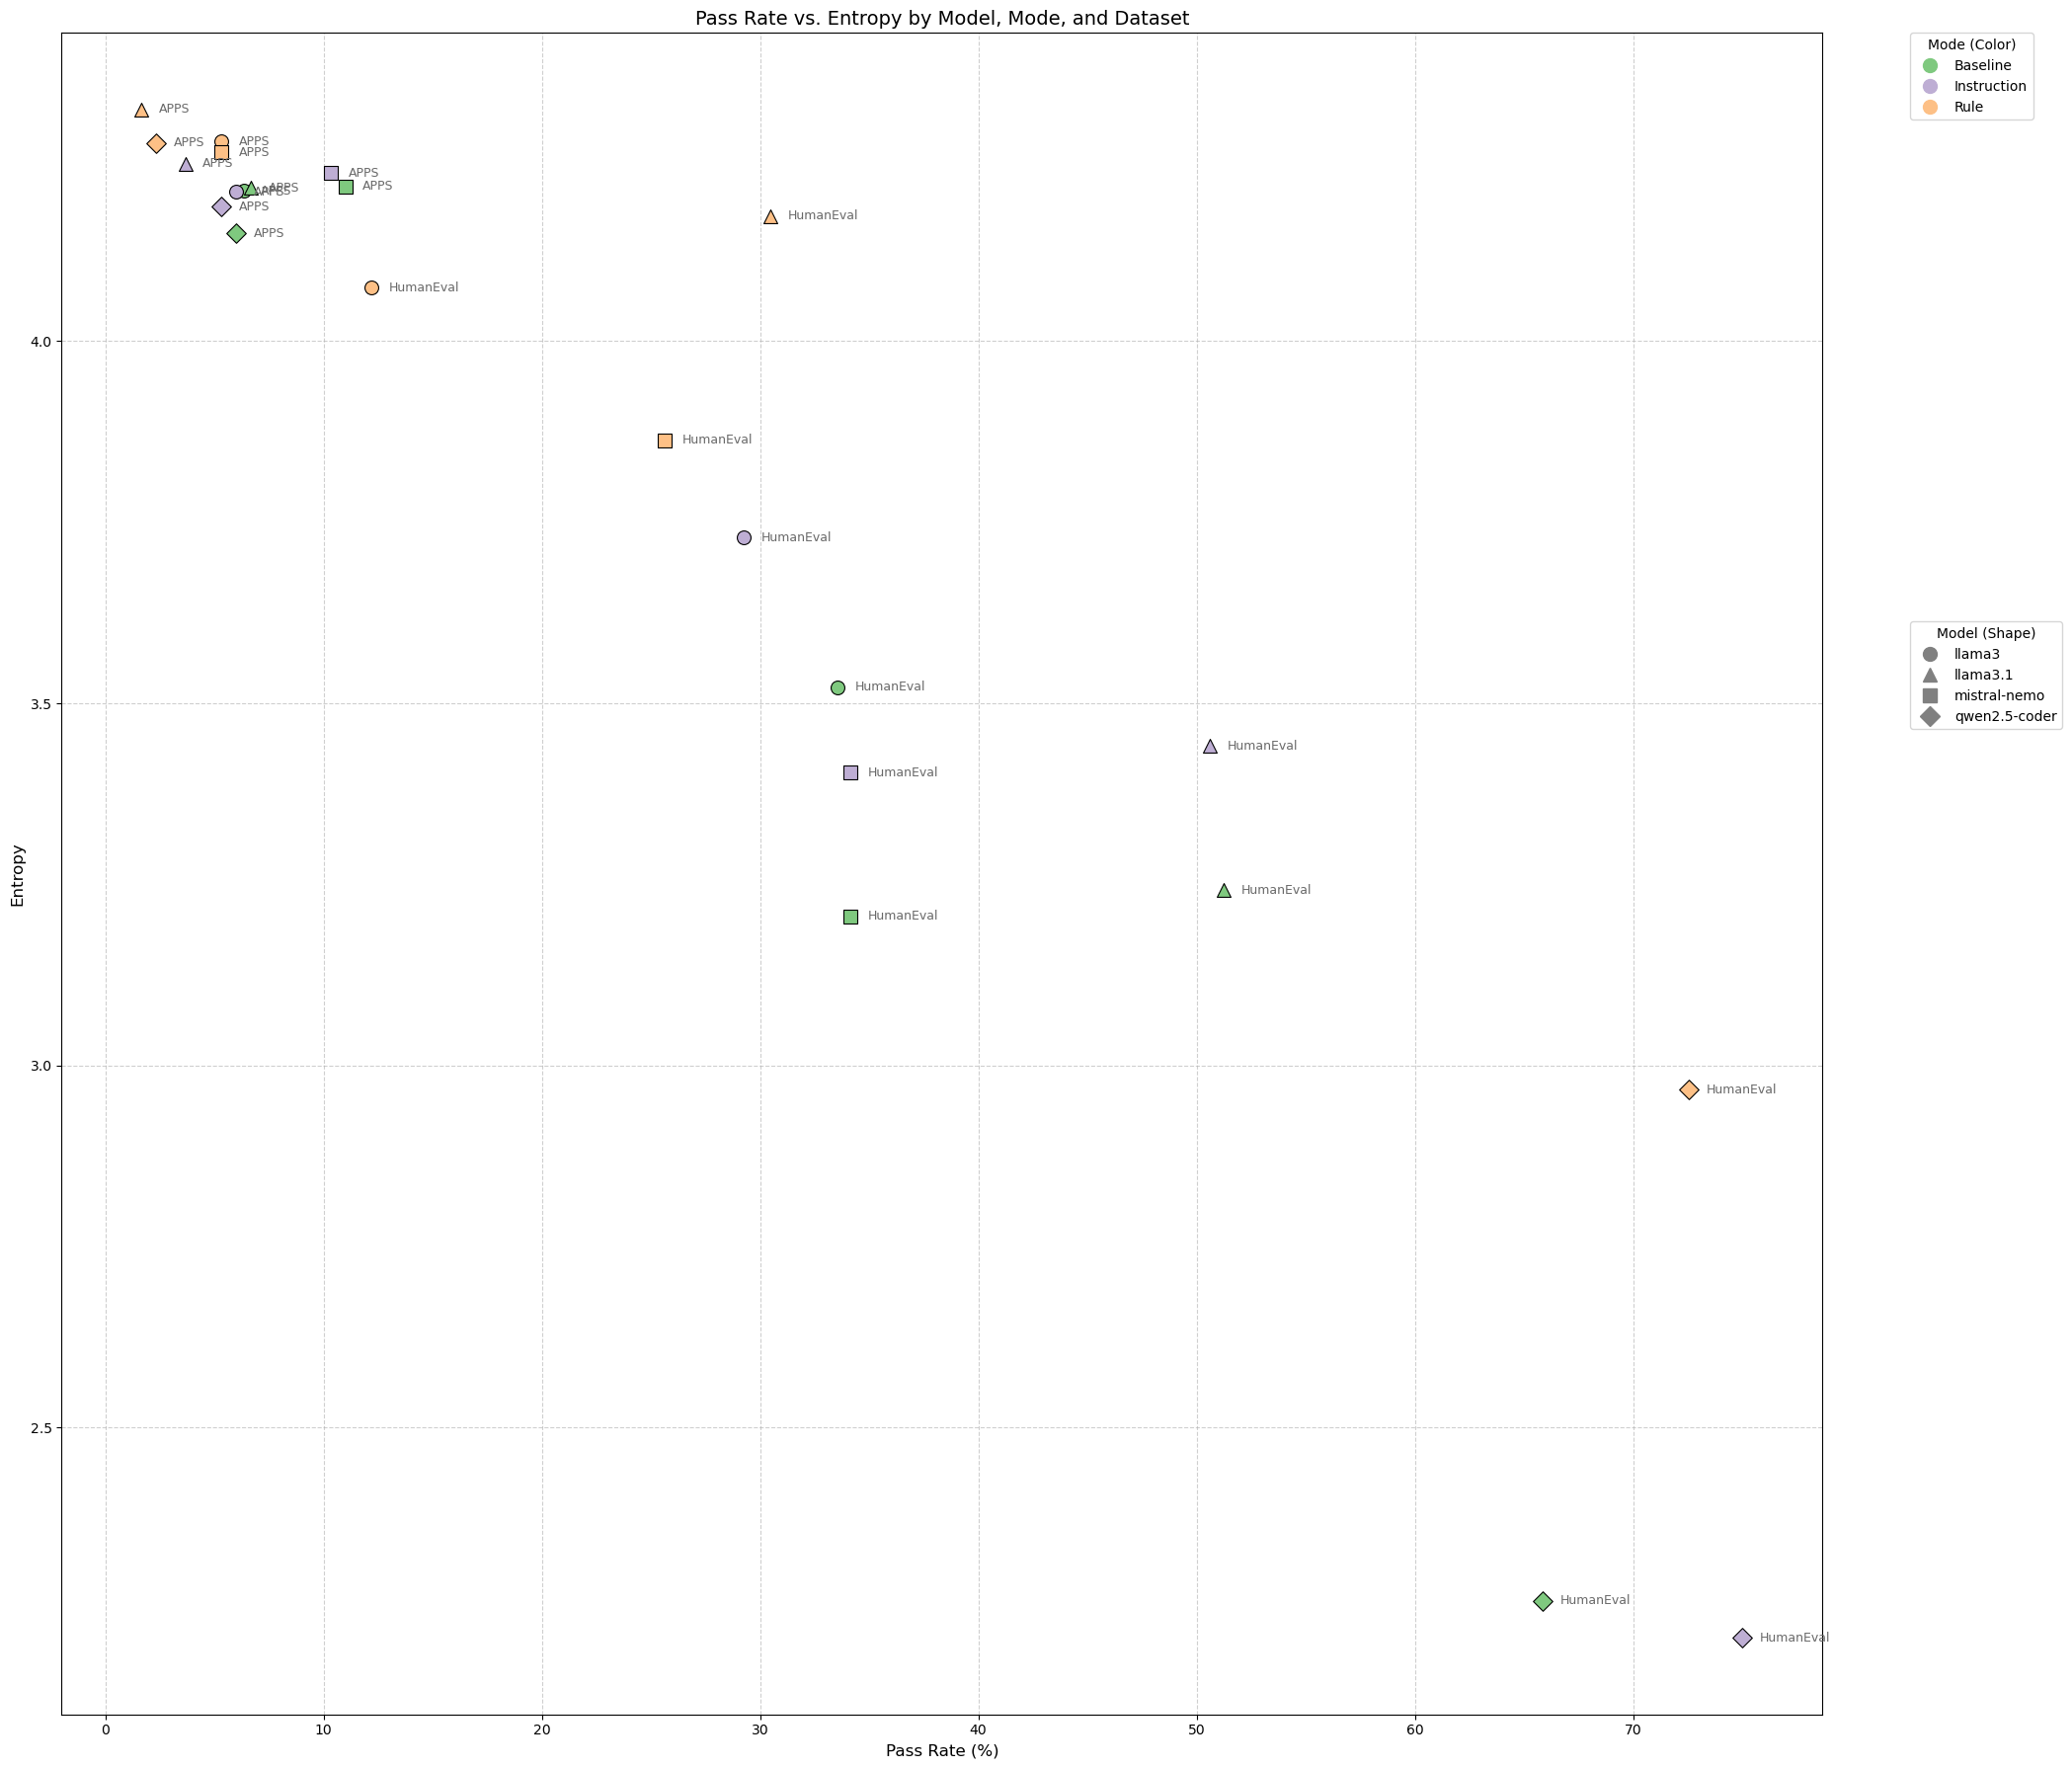

In [32]:
plot_pass_rate_vs_entropy(responses_df)

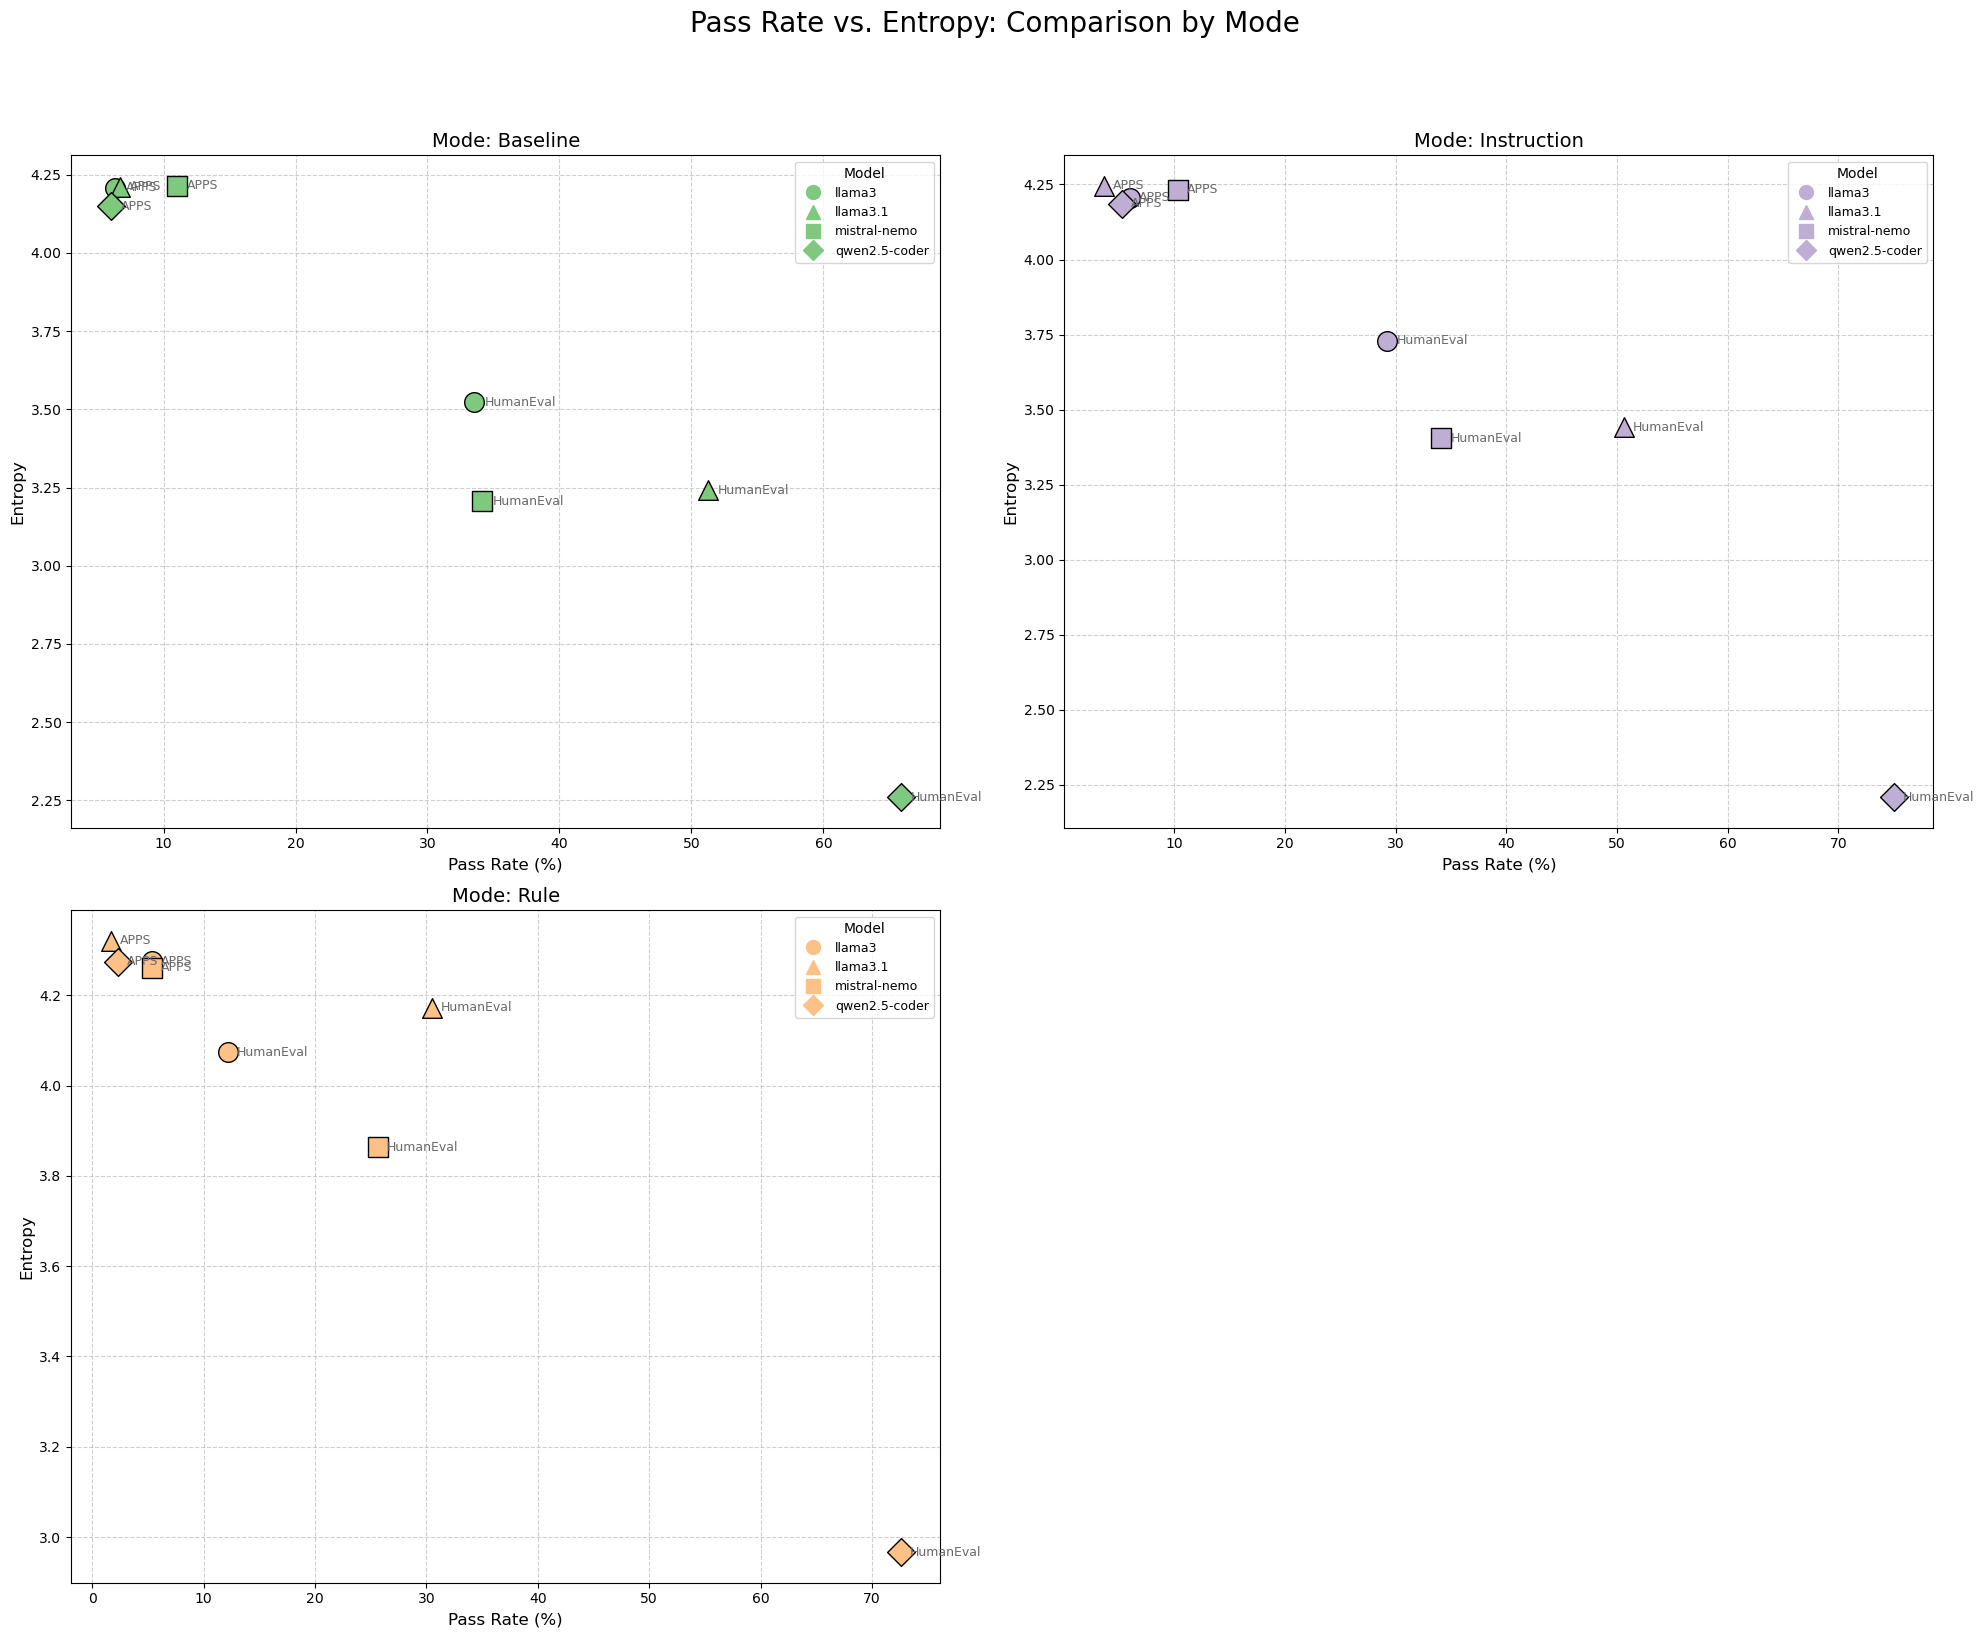

In [33]:
plot_by_mode_subplots(responses_df)

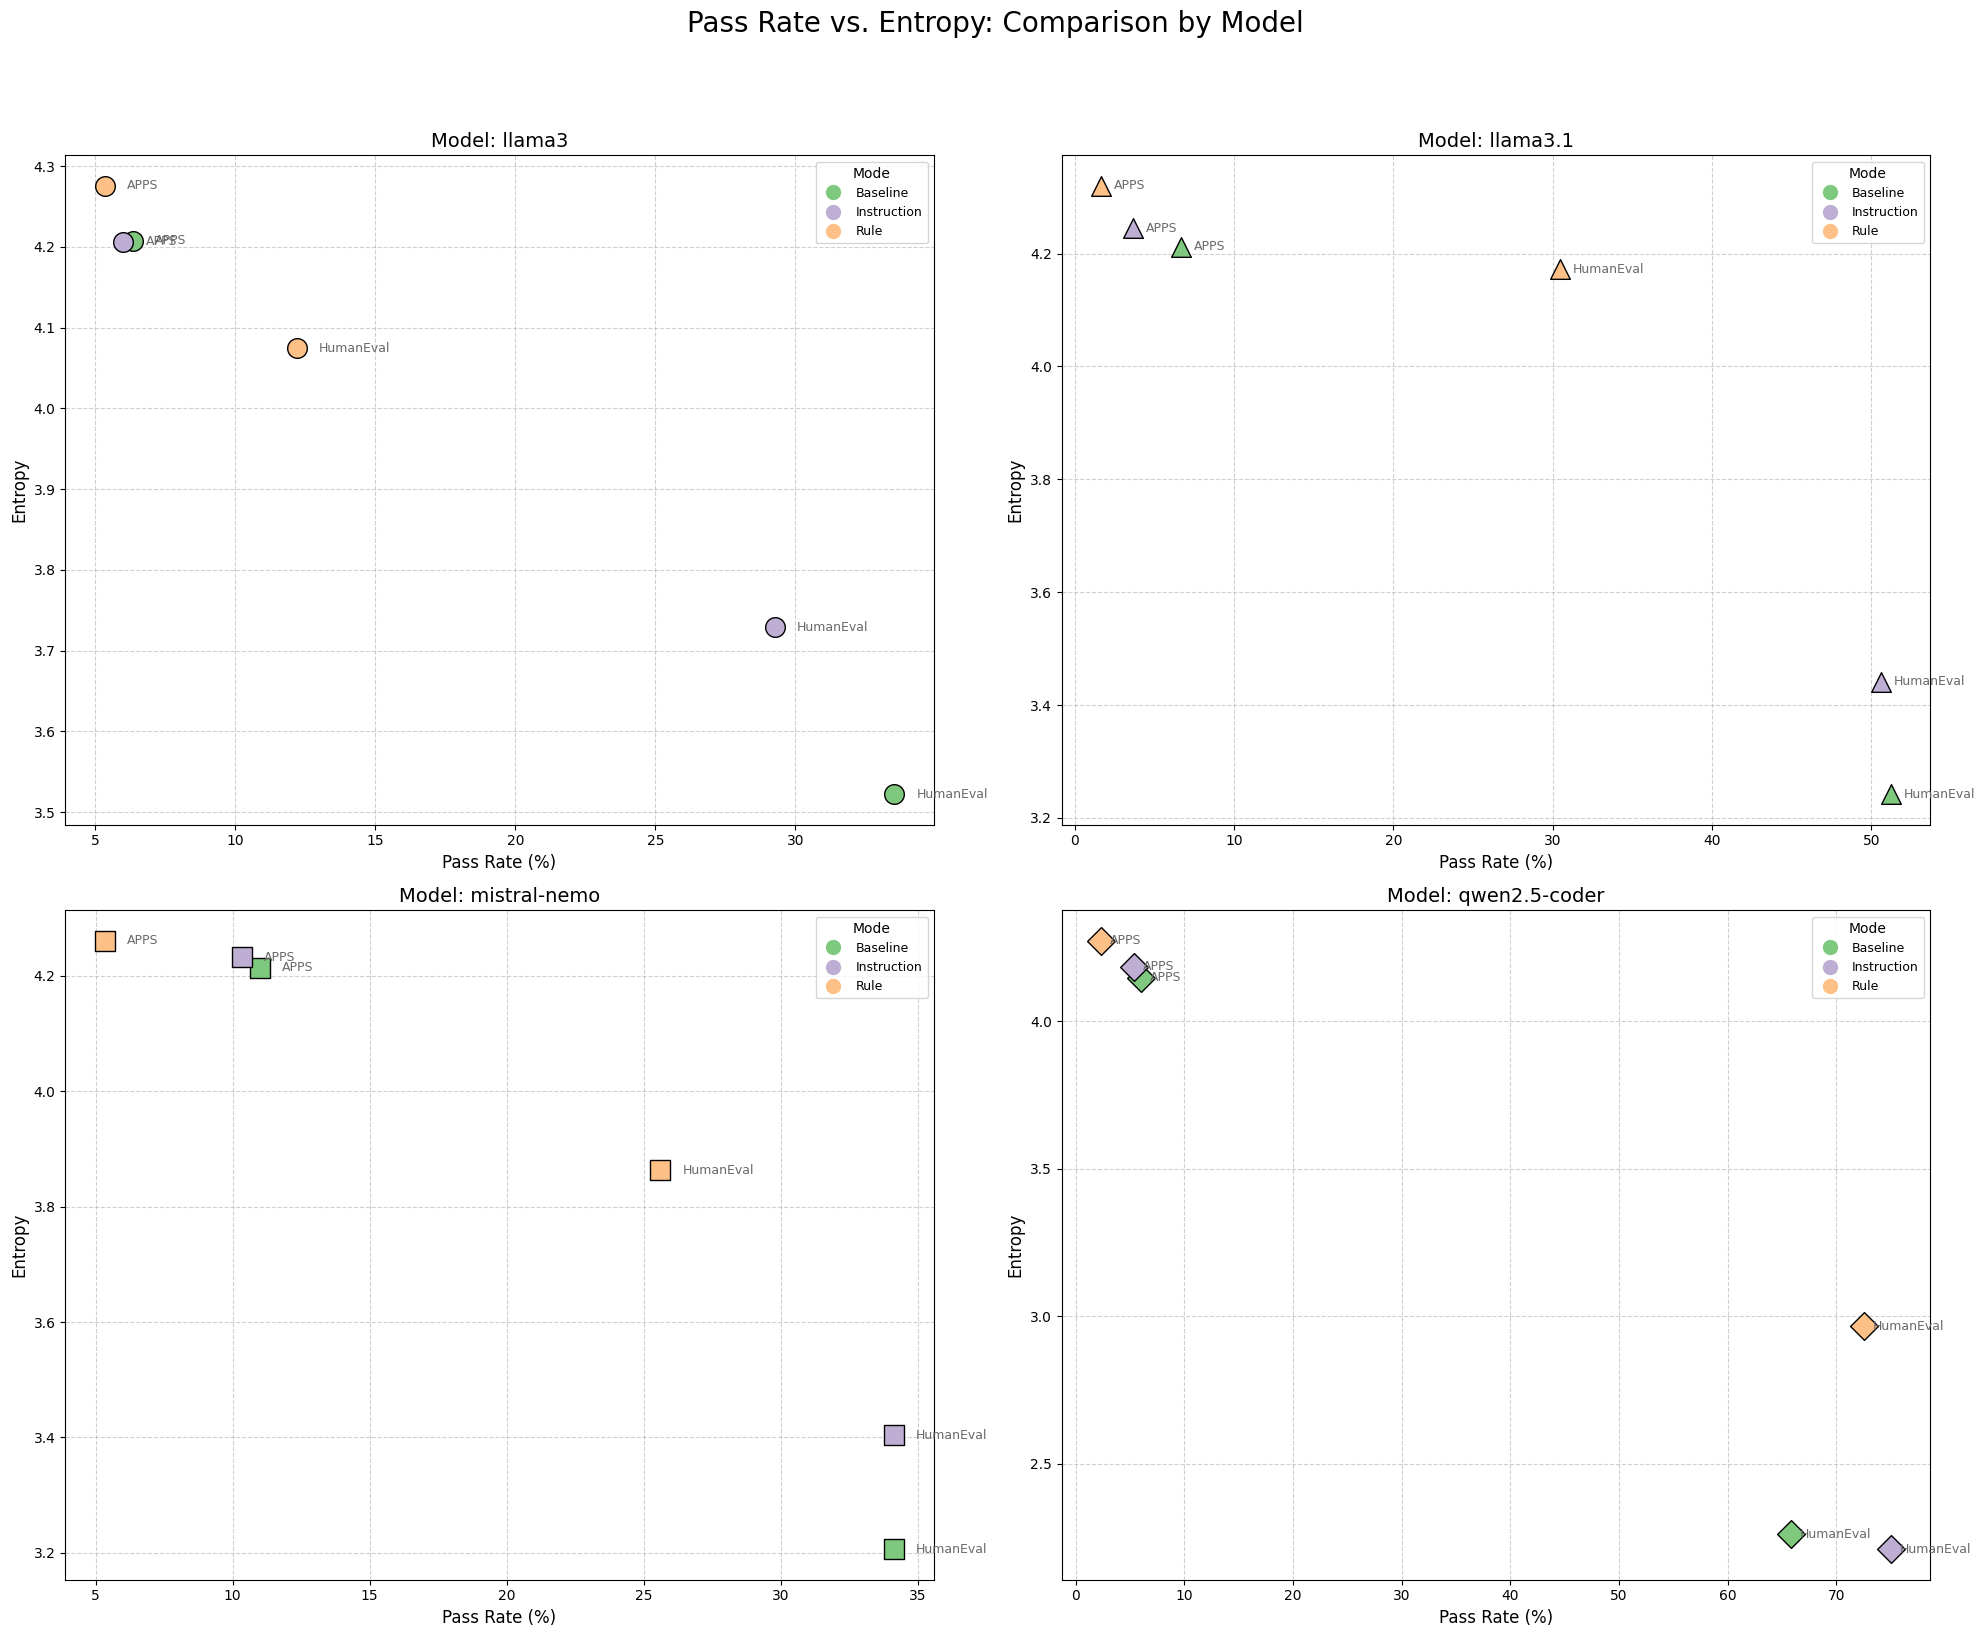

In [ ]:
plot_by_model_subplots(responses_df)